In [1]:
import collections
import pdb
import numpy as np
import pickle
import pdb
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sn
import geopandas as gpd
import random
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import torch

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)


In [2]:
evi_data = pd.read_csv("EVI_stacked.csv")

In [3]:
evi_data.head()

,year,county,long,lat,evi_1,evi_17,evi_33,evi_49,evi_65,evi_81,...,evi_209,evi_225,evi_241,evi_257,evi_273,evi_289,evi_305,evi_321,evi_337,evi_353
0,2001,ADAMS,-91.525,40.075,-0.146923,0.156453,-0.072903,-0.063690,-0.078860,-0.292650,...,-0.287875,0.127960,0.630331,0.057551,0.028800,0.224734,-0.037140,-0.054813,0.095283,0.132038
1,2001,ADAMS,-91.525,40.125,-0.156214,-0.188116,-0.091597,-0.109840,-0.099103,0.021988,...,0.226016,0.078727,-0.084846,0.029688,0.003740,-0.170605,-0.061510,-0.064935,-0.092197,-0.100994
2,2001,ADAMS,-91.525,40.175,0.000551,0.082851,0.108108,0.104726,0.101105,0.126727,...,0.455470,0.454312,0.411025,0.357470,0.320813,0.237779,0.165385,0.161586,0.142840,0.017134
3,2001,ADAMS,-91.525,40.225,-0.005583,0.084916,0.116382,0.115102,0.107363,0.130750,...,0.436069,0.462088,0.436204,0.374752,0.330077,0.250325,0.180660,0.169659,0.148152,0.017000
4,2001,ADAMS,-91.475,39.975,-0.030379,0.079086,0.107433,0.092655,0.078413,0.107965,...,0.544530,0.531395,0.461023,0.335277,0.239753,0.155304,0.102718,0.097096,0.079518,0.084052


In [4]:
evi_data_avg = evi_data.groupby(['year', 'county']).mean()

In [5]:
evi_data_avg = evi_data_avg.drop(evi_data_avg.columns[:7], axis=1)
evi_data_avg.head()

evi_81    evi_97   evi_113   evi_129   evi_145   evi_161  \
year county                                                                  
2001 ADAMS      0.143374  0.196496  0.262141  0.353103  0.331509  0.409800   
     ALEXANDER  0.204903  0.248792  0.307285  0.314606  0.371654  0.410197   
     BOND       0.249409  0.290832  0.340592  0.370450  0.372622  0.446581   
     BOONE      0.143556  0.186420  0.239396  0.272966  0.323822  0.364937   
     BROWN      0.173373  0.235756  0.369283  0.482887  0.470492  0.525438   

                 evi_177   evi_193   evi_209   evi_225   evi_241   evi_257  \
year county                                                                  
2001 ADAMS      0.477934  0.525083  0.554475  0.513934  0.411826  0.310377   
     ALEXANDER  0.540996  0.600168  0.582611  0.526504  0.413138  0.325817   
     BOND       0.588634  0.545340  0.626498  0.589554  0.429155  0.333453   
     BOONE      0.547257  0.587814  0.637542  0.625667  0.493630  0.346854   
     BROWN      0.572867  0.590447  0.617985  0.560700  0.455441  0.361233   

                 evi_273   evi_289   evi_305   evi_321   evi_337   evi_353  
year county                                                                 
2001 ADAMS      0.265210  0.208389  0.167336  0.160516  0.149531  0.127763  
     ALEXANDER  0.275876  0.214323  0.164107  0.151841  0.143559  0.132419  
     BOND       0.293580  0.219287  0.221873  0.213533  0.212430  0.211977  
     BOONE      0.279697  0.226090  0.182578  0.163871  0.152571  0.141265  
     BROWN      0.325221  0.258073  0.213040  0.207031  0.191910  0.177204

# EVI matrix padding

In [6]:
evi_df = pd.read_csv("EVI_stacked.csv")

counties = evi_df['county'].unique()
years = evi_df['year'].unique()

In [7]:
county_dataframes = collections.defaultdict()

In [8]:
# Get padded matrix dimensions for each county and year at which all locations are recorded

max_rows = 150

# Max rows per county
groupedby_county_yr = evi_df.groupby(['year', 'county']).count()
max_locations = pd.DataFrame(groupedby_county_yr.max(axis=1)).groupby('county').max()

# Max columns
max_weeks = 0
for col in evi_df.columns:
    if 'evi' in col:
          max_weeks = max_weeks+1

# Year at which we have complete locations per county
grouped_df = groupedby_county_yr.groupby('county')
year_all_coords = []
for key, item in grouped_df:
  df = grouped_df.get_group(key)
  year_all_coords.append(df['long'].idxmax()[0])

display(max_locations)  # df
print(max_weeks)      # int
print(year_all_coords) # list


,0
county,
ADAMS,104
ALEXANDER,22
BOND,45
BOONE,35
BROWN,46
...,...
WHITESIDE,94
WILL,125
WILLIAMSON,38


23
[2001, 2001, 2001, 2001, 2007, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2013, 2001, 2001, 2001, 2013, 2001, 2010, 2011, 2001, 2010, 2011, 2001, 2001, 2001, 2001, 2005, 2001, 2001, 2007, 2019, 2013, 2001, 2001, 2001, 2001, 2002, 2005, 2001, 2001, 2001, 2001, 2003, 2001, 2001, 2001, 2003, 2010, 2002, 2002, 2001, 2003, 2001, 2001, 2001, 2001, 2001, 2003, 2001, 2003, 2001, 2015, 2001, 2001, 2001, 2001, 2001, 2002, 2007, 2001, 2001, 2001, 2001, 2001, 2015, 2001, 2010, 2001, 2013, 2001, 2019, 2001, 2005, 2001, 2001, 2013, 2001, 2001]


In [9]:
# For each county create a df with indexes the years, columns = columns of evi_df - county
evi_cols = np.delete(evi_df.columns.values, [0,1,2,3])

# interpolated_evi = []

for nr, county in enumerate(counties):
    
    avg_evi = evi_df.groupby('year').mean().drop(['long', 'lat'], axis=1)
    county_df = pd.DataFrame()
    full_coords_df = evi_df[evi_df.county==county][evi_df.year==year_all_coords[0]]

    for yr in years[0:5]: 
        
        sparse_evi = evi_df[evi_df.county==county][evi_df.year==yr]
        county_yr_df = pd.DataFrame()
        county_yr_df['lat'] = full_coords_df.lat
        county_yr_df['long'] = full_coords_df.long

        # Merge EVI based on lat and long
        county_yr_df = county_yr_df.merge(sparse_evi, on=['lat', 'long'], how='left')
        county_yr_df = county_yr_df.drop(['county'], axis=1)
        
        # Remove values below the 0.01 quantile
        for col in evi_cols:
            q = county_yr_df[col].quantile(0.1)

            for i in county_yr_df.index:
                if county_yr_df.loc[i, col] < q:
                    county_yr_df.loc[i, col] = None

        # Replace NaNs with linear interpolation
        county_yr_df = county_yr_df.interpolate(method='linear', axis=0)
    
        # Pad missing rows to reach 150 with average
        times = 150 - county_yr_df.shape[0]
        padding = pd.DataFrame(county_yr_df.mean()).transpose()
        padding = padding.loc[padding.index.repeat(times)].reset_index().drop('index', axis=1)

        county_yr_df = pd.concat([county_yr_df, padding])
        
        # Concatenate to other years
        county_df = pd.concat([county_df, county_yr_df], ignore_index=True)
                
    # Save county to file
#     county_df.to_csv('{}.csv'.format(county))
print(county_df)

/home/varunbabbar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/varunbabbar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


           lat       long    year     evi_1    evi_17    evi_33    evi_49  \
0    40.725000 -89.575000  2001.0  0.005095  0.073189  0.110351  0.125360   
1    40.775000 -89.575000  2001.0  0.005495  0.072284  0.109053  0.123780   
2    40.825000 -89.575000  2001.0  0.000433  0.071380  0.107755  0.122200   
3    40.725000 -89.525000  2001.0 -0.003814  0.050914  0.105038  0.133902   
4    40.775000 -89.525000  2001.0 -0.027751  0.050431  0.102320  0.145604   
..         ...        ...     ...       ...       ...       ...       ...   
745  40.780952 -89.228571  2005.0  0.018143  0.114077  0.121633  0.139549   
746  40.780952 -89.228571  2005.0  0.018143  0.114077  0.121633  0.139549   
747  40.780952 -89.228571  2005.0  0.018143  0.114077  0.121633  0.139549   
748  40.780952 -89.228571  2005.0  0.018143  0.114077  0.121633  0.139549   
749  40.780952 -89.228571  2005.0  0.018143  0.114077  0.121633  0.139549   

       evi_65    evi_81    evi_97  ...   evi_209   evi_225   evi_241  \
0  

## Anomalies plot

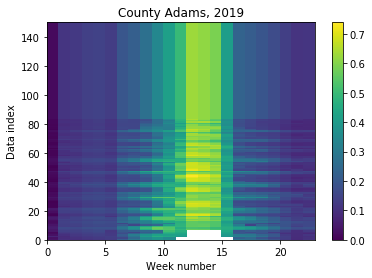

In [10]:
x = county_yr_df.iloc[:, 3:]
    
# fig = plt.plot(figsize=(5,15))
# p1=plt.pcolormesh(x, norm=None)
# plt.xlabel('Week number')
# plt.colorbar(p1)
# plt.ylabel('Data index')
# plt.title('County Adams, 2019')
# plt.savefig('removed_anomalies')


fig = plt.plot(figsize=(5,15))
p2=plt.pcolormesh(x, norm=None)
plt.xlabel('Week number')
plt.colorbar(p2)
plt.ylabel('Data index')
plt.title('County Adams, 2019')
plt.savefig('with_anomalies')




# Data visualisation

In [11]:
# Import files and tidy

tmp_data = pd.read_csv("ERA5.csv")

tmp_data['year'] = tmp_data['time'].str.slice(0, 4)
tmp_data['month'] = tmp_data['time'].str.slice(5, 7)
tmp_data['day'] = tmp_data['time'].str.slice(8, 10)

tmp_data.year = tmp_data.year.astype(int)
tmp_data.month = tmp_data.month.astype(int)
tmp_data.day = tmp_data.day.astype(int)

# date = pd.to_datetime(tmp_data.loc[1, 'time'][:-9], format='%Y-%m-%d')
# new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
# day_of_the_year = (date - new_year_day).days + 1

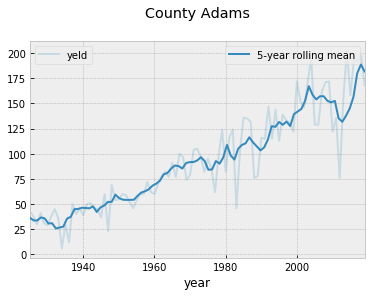

In [12]:
# Plot yield across years for county Adams

crop_yield = pd.read_csv('IL_yield.csv')
plt.style.use('bmh')
width = .35 

for key, item in crop_yield.groupby('county'):
    adams = crop_yield.groupby('county').get_group('ADAMS')

# adams=adams.set_index('year')
adams = adams.drop('county', axis=1)
#adams = adams.merge(adamsT, how='left', on='year')

# adams.plot(x = 'year', y='yield')
# adams.rolling(5).mean().plot(x = 'year', y='yield', secondary_y=True)

fig, ax = plt.subplots()
ax2 = ax.twiny()
adams.plot(x = 'year', y='yield', ax=ax, alpha=0.2)
adams.rolling(5).mean().plot(x = 'year', y='yield', ax=ax2)
ax2.set_xticklabels([])
ax2.axis('off')
ax.legend(['yeld'])
ax2.legend(['5-year rolling mean'])
plt.title('County Adams')

plt.savefig('yield')

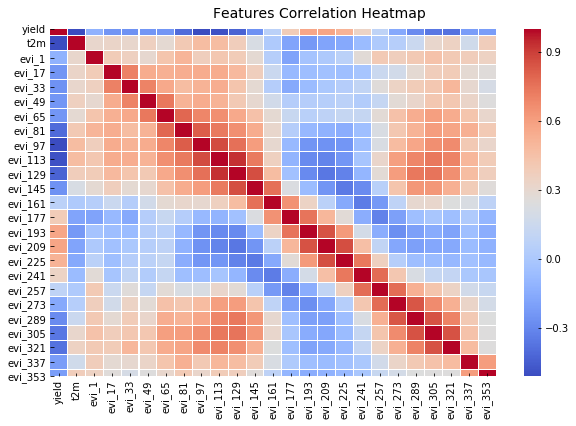

In [13]:
# Correlation heatmap

min_temp = tmp_data.groupby(['year', 'county']).min()
evi_avg = evi_data.groupby(['year', 'county']).mean()


joined = crop_yield.merge(min_temp, on=['year', 'county'], how='left')
joined = joined.merge(evi_avg, on=['year', 'county'], how='left')
joined = joined.drop(['lat_x', 'long_x', 'time', 'month', 'day', 'lat_y', 'long_y'], axis=1)
joined = joined.dropna()

f, ax = plt.subplots(figsize=(10, 6))
corr = joined.drop(['year'], axis=1).corr()
sn.heatmap(round(corr,2), annot=False, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Features Correlation Heatmap', fontsize=14)

plt.savefig('corr_heatmap')

5360


Text(0.5, 1, 'Distribution of EVI across Illinois in 2019')

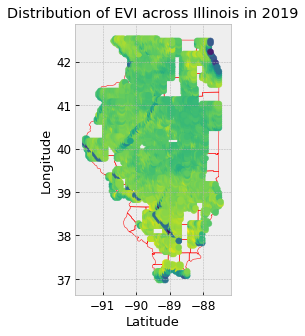

In [14]:
gdf = gpd.read_file("illinois-counties.geojson")
df = pd.read_csv("EVI_stacked.csv")
df_plot = df[df["year"]==2019]
fig, ax = plt.subplots(figsize=(5, 5))
gdf.plot(ax=ax, facecolor='none', edgecolor='red')
print(len(df_plot["evi_17"]))
plt.scatter(df_plot["long"], df_plot["lat"], c = df_plot["evi_1"])
plt.xlabel('Latitude',fontsize=13)
plt.ylabel('Longitude',fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of EVI across Illinois in 2019')

# Data Cleaning and Pre Processing

Text(-0.02, 0.5, 'Datapoint Index')

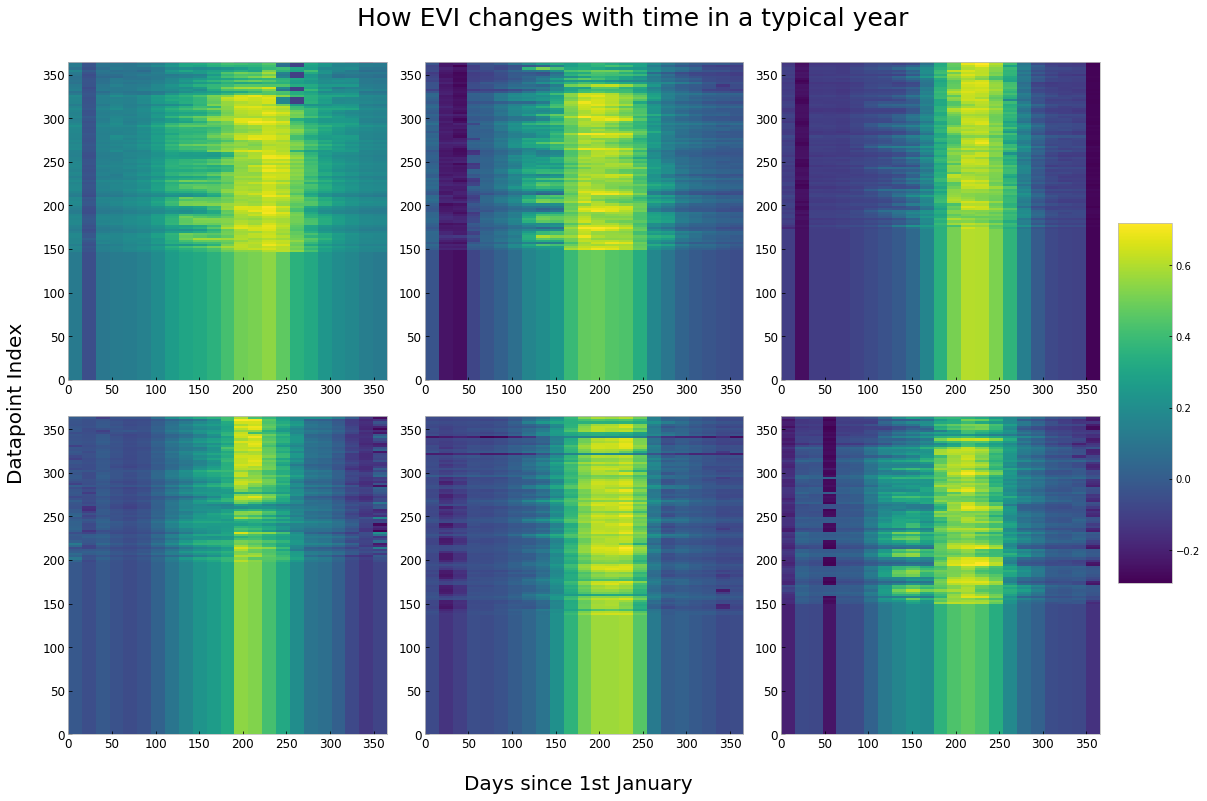

In [15]:
evi_df = pd.read_csv("EVI_stacked.csv")
yield_df = pd.read_csv("IL_yield.csv")
counties = evi_df['county'].unique()
years = evi_df['year'].unique()
# print(evi_df,years)
county_dataframes = {}
yield_counties = {}
anomaly_threshold = 0.96 # The lower the threshold, the further we are from the mean when we flag an anomaly
# Get county-wise and year-wise data, i.e. access the evi dataframe for county ADAMS in year 2003
maximum_data_length = 0
max_columns = 0
for county in counties:
    year_dataframes = {}
    df_county = evi_df[evi_df['county'] == county]
    for year in years:
        df_year = df_county[df_county['year'] == year]
        year_dataframes[year] = df_year
        maximum_data_length = max(maximum_data_length,len(df_year['long']))
        max_columns = max(max_columns,len(df_year.columns))
    county_dataframes[county] = year_dataframes
adams_2001 = county_dataframes['ADAMS'][2001]
i = 0
for county in counties:
    year_evis = {}
    df_county = yield_df[yield_df['county'] == county]
    yield_years = {}
    for year in years:
        df_year = county_dataframes[county][year]
        df_year_yield = df_county[df_county['year'] == year]
        evi_matrix = np.zeros((len(df_year),23))
        loc_matrix = np.zeros((len(df_year),2))
        if not df_year.empty and not df_year_yield.empty: # Only consider non empty dataframes
#             temp_df = era_df[era_df['county'] == county][era_df['year'] == year]
            yield_years[year] = np.array(df_year_yield['yield'])[0]
            i = 0
            for column in df_year:
                if 'evi' in column:
                    evis = np.array(df_year[column]) # 
                    evis = np.reshape(evis,(len(evis),1))
                    evi_matrix[:,i] = evis[:,0] # Storing the evi data for a given county for a given year in a matrix
                    i += 1
                else:
                    if 'lat' in column: # Getting the latitude and longitude values
                        lats = np.array(df_year[column])
                        loc_matrix[:,0] = lats
                        
                    if 'long' in column:
                        longs = np.array(df_year[column])
                        loc_matrix[:,1] = longs
                        
            mean = evi_matrix.mean() # Mean of the matrix
            del_indices = []
            for i in range(len(evi_matrix)):
                if np.exp(-(evi_matrix[i].mean()-mean)**2) < anomaly_threshold: # If the current row is deemed to be anomalous
                    del_indices.append(i) # We flag the index for deletion
            new_mat = np.delete(evi_matrix,del_indices,axis=0)
            new_locs = np.delete(loc_matrix,del_indices,axis=0)
            padded_stuff = np.zeros((maximum_data_length-len(new_mat),23)) 
            # After deleting the anomalous rows, we just pad the remaining atrix with the max sequence length
            loc_padding = np.zeros((maximum_data_length-len(new_mat),2))
            j = 0
            for column in df_year:
                if 'evi' in column:
                    evis = np.array(df_year[column])
                    mean = np.mean(evis)
                    padded_stuff[:,j] = np.array([np.mean(evis)]*(maximum_data_length-len(new_mat)))
                    # We pad the cleaned matrix with the average value of the remaining points per column
                    j += 1
                elif 'lat' in column:
                    lats = np.array(df_year[column])
                    mean = np.mean(lats)
                    loc_padding[:,0] = np.array([np.mean(lats)]*(maximum_data_length-len(new_mat)))
                    # We pad the cleaned matrix with the average value of the remaining points per column
                elif 'long' in column:
                    longs = np.array(df_year[column])
                    mean = np.mean(longs)
                    loc_padding[:,1] = np.array([np.mean(longs)]*(maximum_data_length-len(new_mat)))
                    # We pad the cleaned matrix with the average value of the remaining points per column
    
            cleaned_matrix = np.concatenate((new_mat,padded_stuff),axis=0)
            cleaned_lats = np.concatenate((new_locs,loc_padding),axis=0)
            year_evis[year] = {'evis':cleaned_matrix,'locs': cleaned_lats}
    yield_counties[county] = yield_years
    county_dataframes[county] = {'yearwise_dictionary': county_dataframes[county],'evis_locs': year_evis}
    
# plt.figure(figsize=(10,10))

ncolors = 20
alpha_max = 1
    
base_color = [0.35294117647058826, 0.6313725490196078, 0.1568627450980392]
#damping = 1.1

color_array = np.linspace(base_color + [0], base_color + [alpha_max], ncolors) #np.array([base_color]*ncolors)
# change alpha values
#color_array[:,-1] = np.linspace(0.0, alpha_max ** (1/damping), ncolors) ** (damping)

new_cmp = mpl.colors.ListedColormap(list(color_array), 'new_cmap', N=ncolors)
        
mat1 = county_dataframes['ADAMS']['evis_locs'][2019]['evis']
mat2 = county_dataframes['WARREN']['evis_locs'][2009]['evis']
mat3 = county_dataframes['ADAMS']['evis_locs'][2011]['evis']
mat4 = county_dataframes['WINNEBAGO']['evis_locs'][2003]['evis']
mat5 = county_dataframes['WHITESIDE']['evis_locs'][2006]['evis']
mat6 = county_dataframes['ADAMS']['evis_locs'][2013]['evis']
fig,ax1 = plt.subplots(nrows=2, ncols=3,figsize=(15,10))
plt.tight_layout()

im = ax1[0,0].imshow(mat1,extent = [0,365,0,365])
ax1[0,2].imshow(mat2,extent = [0,365,0,365])
ax1[0,1].imshow(mat3,extent = [0,365,0,365])
ax1[1,0].imshow(mat4,extent = [0,365,0,365])
ax1[1,1].imshow(mat5,extent = [0,365,0,365])
ax1[1,2].imshow(mat6,extent = [0,365,0,365])
cbar_ax = fig.add_axes([1, 0.25, 0.05, 0.5])
fig.colorbar(im,cax=cbar_ax)
for i in range(len(ax1)):
    for j in range(len(ax1[0])):
        ax1[i,j].grid(False)
        ax1[i,j].tick_params(axis='both', which='major', labelsize=12)
        ax1[i,j].tick_params(axis='both', which='minor', labelsize=12)
fig.suptitle("How EVI changes with time in a typical year",fontsize=25,y=1.05,x=0.55)
fig.text(0.5, -0.03, 'Days since 1st January', ha='center', va='center',fontsize=20)
fig.text(-0.02, 0.5, 'Datapoint Index', ha='center', va='center',fontsize=20,rotation='vertical')
# plt.subplots_adjust(wspace=0.05, hspace=0.01)

# plt.imshow(mat2)


# CNN Architecture
Architecture modified from https://github.com/gabrieltseng/pycrop-yield-prediction. 

In [16]:
import torch
from torch import nn
import torch.nn.functional as F
from pathlib import Path
import torch.utils.data as data
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

class ConvNet(nn.Module):
    """
    A crop yield conv net.
    For a description of the parameters, see the ConvModel class.
    Only handles strides of 1 and 2
    """
    def __init__(self, in_channels=1, dropout=0.4, dense_features=None):
        super().__init__()

        # values taken from the paper
        in_out_channels_list = [in_channels, 64, 32, 16]
        stride_list = [None, 1, 2, 2]

        # Figure out the size of the final flattened conv layer, which
        # is dependent on the input size
        num_divisors = sum([1 if i == 2 else 0 for i in stride_list])
#         for i in range(num_divisors):
#             if time % 2 != 0:
#                 time += 1
#             time /= 2

        if dense_features is None:
            dense_features = [3648,2048, 1]
#         dense_features.insert(0, int(in_out_channels_list[-1] * time * 4))

        assert len(stride_list) == len(in_out_channels_list), \
            "Stride list and out channels list must be the same length!"

        self.convblocks = nn.ModuleList([
            ConvBlock(in_channels=in_out_channels_list[i-1],
                      out_channels=in_out_channels_list[i],
                      kernel_size=3, stride=stride_list[i],
                      dropout=dropout) for
            i in range(1, len(stride_list))
        ])

        self.dense_layers = nn.ModuleList([
            nn.Linear(in_features=dense_features[i-1],
                      out_features=dense_features[i]) for
            i in range(1, len(dense_features))
        ])

        self.initialize_weights()

    def initialize_weights(self):
        for convblock in self.convblocks:
            nn.init.kaiming_uniform_(convblock.conv.weight.data)
            # http://cs231n.github.io/neural-networks-2/#init
            # see: Initializing the biases
            nn.init.constant_(convblock.conv.bias.data, 0)
        for dense_layer in self.dense_layers:
            nn.init.kaiming_uniform_(dense_layer.weight.data)
            nn.init.constant_(dense_layer.bias.data, 0)

    def forward(self, x, return_last_dense=False):
        """
        If return_last_dense is true, the feature vector generated by the second to last
        dense layer will also be returned. This is then used to train a Gaussian Process model.
        """
        for block in self.convblocks:
            x = block(x)

        x = x.view(x.shape[0], -1)
        y = x
#         print(x.shape)
        for layer_number, dense_layer in enumerate(self.dense_layers):
            
            x = dense_layer(x)
            if return_last_dense and (layer_number == len(self.dense_layers) - 2):
                output = x
                weight = dense_layer.weight
                bias = dense_layer.bias
                
        if return_last_dense:
#             print(x.shape,y.shape,self.dense_layers[0].weight.shape,self.dense_layers[0].bias.shape)
            return x, self.dense_layers[0](y),self.dense_layers[1].weight,self.dense_layers[1].bias
        return x
    
class ConvBlock(nn.Module):
    """
    A 2D convolution, followed by batchnorm, a ReLU activation, and dropout
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, dropout):
        super().__init__()
        self.conv = Conv2dSamePadding(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride)
        self.batchnorm = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.relu(self.batchnorm(self.conv(x)))
        return self.dropout(x)


class Conv2dSamePadding(nn.Conv2d):
    """Represents the "Same" padding functionality from Tensorflow.
    See: https://github.com/pytorch/pytorch/issues/3867
    This solution is mostly copied from
    https://github.com/pytorch/pytorch/issues/3867#issuecomment-349279036
    Note that the padding argument in the initializer doesn't do anything now
    """
    def forward(self, input):
        return conv2d_same_padding(input, self.weight, self.bias, self.stride,
                                   self.dilation, self.groups)


def conv2d_same_padding(input, weight, bias=None, stride=1, dilation=1, groups=1):
    # stride and dilation are expected to be tuples.

    # first, we'll figure out how much padding is necessary for the rows
    input_rows = input.size(2)
    filter_rows = weight.size(2)
    effective_filter_size_rows = (filter_rows - 1) * dilation[0] + 1
    out_rows = (input_rows + stride[0] - 1) // stride[0]
    padding_rows = max(0, (out_rows - 1) * stride[0] + effective_filter_size_rows - input_rows)
    rows_odd = (padding_rows % 2 != 0)

    # same for columns
    input_cols = input.size(3)
    filter_cols = weight.size(3)
    effective_filter_size_cols = (filter_cols - 1) * dilation[1] + 1
    out_cols = (input_cols + stride[1] - 1) // stride[1]
    padding_cols = max(0, (out_cols - 1) * stride[1] + effective_filter_size_cols - input_cols)
    cols_odd = (padding_cols % 2 != 0)

    if rows_odd or cols_odd:
        input = F.pad(input, [0, int(cols_odd), 0, int(rows_odd)])

    return F.conv2d(input, weight, bias, stride,
                    padding=(padding_rows // 2, padding_cols // 2),
                    dilation=dilation, groups=groups)

class Dataset(data.Dataset):
    def __init__(self,county_dataframes,yields):
        super(Dataset, self).__init__()
        length = 0
        for county in county_dataframes:
            for year in county:
                length += 1
        self.data = torch.zeros((length,1,150,23))
        self.target = torch.zeros((length,1))
        counter = 0
        for county in county_dataframes:
            for year in county_dataframes[county]['evis_locs']:
                if counter < len(self.data):
                    self.data[counter,:,:,:] = torch.Tensor(county_dataframes[county]['evis_locs'][year]['evis'])
                    self.target[counter] = torch.Tensor([yields[county][year]])
                counter += 1
        
        self.data_mean = self.data.mean()
        self.data_std = self.data.std()
        self.target_mean = self.target.mean()
        self.target_std = self.target.std()
        self.data = (self.data-self.data.mean())/self.data.std()
        print(self.target.mean())
#         self.target = (self.target-self.target.mean())/self.target.std()
        
    def __getitem__(self, index):
#         print(self.target[index])
        return self.data[index,:,:,:], self.target[index]

    def __len__(self):
        return len(self.data)
    
    def get_moments(self):
        return self.data_mean,self.data_std,self.target_mean,self.target_std

# Training the Network

tensor(157.1608)
646
Epoch:0
Iteration:9
Validation Mean Squared Error (MSE): tensor(3263.6946, device='cuda:0')
Epoch:1
Iteration:9
Validation Mean Squared Error (MSE): tensor(1449.2032, device='cuda:0')
Epoch:2
Iteration:9
Validation Mean Squared Error (MSE): tensor(494.7274, device='cuda:0')
Epoch:3
Iteration:9
Validation Mean Squared Error (MSE): tensor(4383.4263, device='cuda:0')
Epoch:4
Iteration:9
Validation Mean Squared Error (MSE): tensor(2048.5813, device='cuda:0')
Epoch:5
Iteration:9
Validation Mean Squared Error (MSE): tensor(1471.3835, device='cuda:0')
Epoch:6
Iteration:9
Validation Mean Squared Error (MSE): tensor(1591.4181, device='cuda:0')
Epoch:7
Iteration:9
Validation Mean Squared Error (MSE): tensor(777.1993, device='cuda:0')
Epoch:8
Iteration:9
Validation Mean Squared Error (MSE): tensor(1548.6213, device='cuda:0')
Epoch:9
Iteration:9
Validation Mean Squared Error (MSE): tensor(510.2680, device='cuda:0')
Epoch:10
Iteration:9
Validation Mean Squared Error (MSE): tens

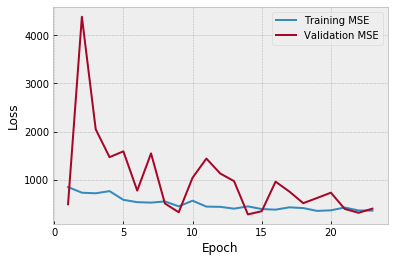

In [17]:
data = Dataset(county_dataframes,yield_counties)
dmean,dstd,lmean,lstd = data.get_moments()

validation_split = .2
shuffle_dataset = True
random_seed = 42
batch_size = 16

dataset_size = len(data)
print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
# print(train_indices,val_indices)
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                                sampler=valid_sampler)

def train(training_data_loader, validation_loader,optimizer, model, criterion, epoch):
    model.train()
    training_loss = 0
    for iteration, batch in enumerate(training_data_loader, 1):
        inp, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)
#         print(inp.shape)
        if torch.cuda.is_available():
            inp = inp.cuda()
            target = target.cuda()

        output = model(inp)
        loss = criterion(target,output)
        training_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    training_loss /= len(training_data_loader)
    validation_loss = 0
    torch.cuda.empty_cache()
    model.eval()
    with torch.no_grad():
        for iteration, batch in enumerate(validation_loader, 1): 
            inp, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)
    #         print(inp.shape)
            if torch.cuda.is_available():
                inp = inp.cuda()
                target = target.cuda()
            output = model(inp)
            
            loss = criterion(target,output)
            validation_loss += loss
        validation_loss /= len(validation_loader)
        torch.cuda.empty_cache()
    print("Epoch:" + str(epoch))
    print("Iteration:" + str(iteration))
    print("Validation Mean Squared Error (MSE): "+ str(validation_loss))
    return training_loss,validation_loss

cnn = ConvNet()
cnn.cuda()
val_loss = []
train_loss = []
num_epochs = 25
lr = 0.001
for epoch in range(num_epochs):
    training_loss, validation_loss= train(training_data_loader=train_loader,validation_loader=validation_loader,optimizer=optim.Adam(cnn.parameters(),lr=lr),model=cnn,criterion=nn.MSELoss(),epoch=epoch)
    lr *= np.exp(-0.05)
    val_loss.append(validation_loss)
    train_loss.append(training_loss)
plt.plot(np.arange(3,num_epochs+1)-2,np.array(train_loss)[2:],label='Training MSE')
plt.plot(np.arange(3,num_epochs+1)-2,np.array(val_loss)[2:],label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()



# Gaussian Process Model
Here we initialise a Gaussian Process Model (modified from https://github.com/gabrieltseng/pycrop-yield-prediction) and add use the features from the final layer of the CNN as inputs to this model

In [18]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import math

class GaussianProcess:
    """
    The crop yield Gaussian process
    """
    def __init__(self, sigma=1, r_loc=0.5, r_year=1.5, sigma_e=0.32, sigma_b=0.01):
        self.sigma = sigma
        self.r_loc = r_loc
        self.r_year = r_year
        self.sigma_e = sigma_e
        self.sigma_b = sigma_b

    @staticmethod
    def _normalize(x):
        x_mean = np.mean(x, axis=0, keepdims=True)
        x_scale = np.ptp(x, axis=0, keepdims=True)

        return (x - x_mean) / x_scale

    def run(self, feat_train, feat_test, loc_train, loc_test,
            train_yield, model_weights, model_bias):

        # makes sure the features have an additional testue for the bias term
        # We call the features H since the features are used as the basis functions h(x)
        H_train = np.concatenate((feat_train, np.ones((feat_train.shape[0], 1))), axis=1)
        H_test = np.concatenate((feat_test, np.ones((feat_test.shape[0], 1))), axis=1)
#         H_train = feat_train
#         H_test = feat_test
        Y_train = np.expand_dims(train_yield, axis=1)

        n_train = feat_train.shape[0]
        n_test = feat_test.shape[0]

        locations = self._normalize(np.concatenate((loc_train, loc_test), axis=0))
#         years = self._normalize(np.concatenate((year_train, year_test), axis=0))
        # to calculate the se_kernel, a dim=2 array must be passed
#         years = np.expand_dims(years, axis=1)

        # These are the squared exponential kernel function we'll use for the covariance
        se_loc = squareform(pdist(locations, 'euclidean')) ** 2 / (self.r_loc ** 2)
#         se_year = squareform(pdist(years, 'euclidean')) ** 2 / (self.r_year ** 2)

        # make the dirac matrix we'll add onto the kernel function
        noise = np.zeros([n_train + n_test, n_train + n_test])
        noise[0: n_train, 0: n_train] += (self.sigma_e ** 2) * np.identity(n_train)

        kernel = ((self.sigma ** 2) * np.exp(-se_loc)) + noise

        # since B is diagonal, and B = self.sigma_b * np.identity(feat_train.shape[1]),
        # its easy to calculate the inverse of B
        B_inv = np.identity(H_train.shape[1]) / self.sigma_b
        # "We choose b as the weight vector of the last layer of our deep models"
        b = np.concatenate((model_weights, np.expand_dims(model_bias,1)),axis=1).T
        
        K_inv = np.linalg.inv(kernel[0: n_train, 0: n_train])
        # The definition of beta comes from equation 2.41 in Rasmussen (2006)
#         print(b.shape,K_inv.shape,H_train.shape,B_inv.shape,Y_train.shape)
        beta = np.linalg.inv(B_inv + H_train.T.dot(K_inv).dot(H_train)).dot(
            H_train.T.dot(K_inv).dot(Y_train) + B_inv.dot(b))
        
        # We take the mean of g(X*) as our prediction, also from equation 2.41
        pred = H_test.dot(beta) + \
               kernel[n_train:, :n_train].dot(K_inv).dot(Y_train - H_train.dot(beta))

        return pred
counter = 0
length = 0
val_proportion = 0.2
for county in county_dataframes:
    for year in county:
        length += 1
last_features_train = torch.zeros((length,2048))
locs = torch.zeros((length,300))
target = torch.zeros((length))
for county in county_dataframes:
    for year in county_dataframes[county]['evis_locs']:
        if counter < length:
            x = torch.Tensor(county_dataframes[county]['evis_locs'][year]['evis']).unsqueeze(0).unsqueeze(0).cuda()
            x = (x-dmean)/dstd
            pred, last_feature,weight,bias = cnn.forward(x,return_last_dense=True)
            last_features_train[counter,:] = last_feature
            target[counter] = torch.Tensor([yield_counties[county][year]])
            locs[i,:] = torch.cat((torch.Tensor(county_dataframes[county]['evis_locs'][year]['locs'])[:,0],torch.Tensor(county_dataframes[county]['evis_locs'][year]['locs'])[:,1]))
            counter += 1
            
last_features_train = np.array(last_features_train.detach().cpu())
last_features_train = last_features_train[:math.floor(length-val_proportion*length),:]
last_features_val = last_features_train[:math.floor(val_proportion*length),:]

locs = np.array(locs.detach().cpu())
locs_train = locs[:math.floor(length-val_proportion*length),:]
locs_val = locs[:math.floor(val_proportion*length),:]

target_train = np.array(target[:math.floor(length-val_proportion*length)])
target_val = np.array(target[:math.floor(val_proportion*length)])
weight = np.array(weight.detach().cpu())
bias = np.array(bias.detach().cpu())

gp = GaussianProcess()
pred = gp.run(last_features_train,last_features_val,locs_train,locs_val,target_train,weight,bias)

# Getting Predictions
Here, we get predictions from the CNN both with and without the addition of the GP model. The GP model achieves similar error as the CNN model, but mostly tends to make more optimistic yield predictions

In [19]:
def get_actual_vals(validation_loader,model):
    torch.cuda.empty_cache()
    model.eval()
    preds = []
    actual_vals = []
    inputs = []
    with torch.no_grad():
        for iteration, batch in enumerate(validation_loader, 1):
            inp, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)
            for i in target:
                actual_vals.append(float(i.cpu()))
            for i in inp:
                inputs.append(i.cpu())    
    return actual_vals,inputs
actual_vals,inputs = get_actual_vals(validation_loader,cnn)

prediction_dataframe = pd.DataFrame(columns=['Actual Yield', 'CNN Predicted Yield','CNN + GP Predicted Yield','County','Year'])
j = 0
cnn.eval()
gp_cnn_error = 0
cnn_error = 0
for i in range(len(inputs)):
    x = inputs[i]
    y = float(actual_vals[i])
    x = x.unsqueeze(0).cuda()
    y_pred, last_feature,weight,bias = cnn.forward(x,return_last_dense=True) 
    y_pred = round(float(y_pred.cpu()),2)
    last_feature = np.array(last_feature.detach().cpu())
    weight = np.array(weight.detach().cpu())
    bias = np.array(bias.detach().cpu())
    locs = torch.cat((torch.Tensor(county_dataframes[county]['evis_locs'][year]['locs'])[:,0],torch.Tensor(county_dataframes[county]['evis_locs'][year]['locs'])[:,1])).unsqueeze(0)        
    y_pred_gp_cnn = float(gp.run(last_features_train,last_feature,locs_train,locs,target_train,weight,bias))
    j += 1
    print("hi",j)
    gp_cnn_error += np.abs(y_pred_gp_cnn-y)/y
    cnn_error += np.abs(y_pred-y)/y
        
cnn_error /= len(actual_vals)
gp_cnn_error /= len(actual_vals)
print("Average Error made by the CNN model is: " + str(cnn_error))
print("Average Error made by the CNN + GP model is: " + str(gp_cnn_error))

prediction_dataframe = pd.DataFrame(columns=['Actual Yield', 'CNN Predicted Yield','CNN + GP Predicted Yield','County','Year'])

j = 0
for county in county_dataframes:
    for year in county_dataframes[county]['evis_locs']:
        rand = np.random.rand()
        if rand < 0.01: # Getting a set of random predictions
            x = torch.Tensor(county_dataframes[county]['evis_locs'][year]['evis'])
            y = float(torch.Tensor([yield_counties[county][year]]).cpu())
            y = round(y,2)
            
            x = x.unsqueeze(0).unsqueeze(0).cuda()
            x = (x-dmean)/dstd
            
            y_pred,last_feature,weight,bias = cnn.forward(x,return_last_dense=True) 
            last_feature = np.array(last_feature.detach().cpu())
            weight = np.array(weight.detach().cpu())
            bias = np.array(bias.detach().cpu())
            y_pred = round(float(y_pred.cpu()),2)
            
            locs = torch.cat((torch.Tensor(county_dataframes[county]['evis_locs'][year]['locs'])[:,0],torch.Tensor(county_dataframes[county]['evis_locs'][year]['locs'])[:,1])).unsqueeze(0)
            y_pred_gp_cnn = float(gp.run(last_features_train,last_feature,locs_train,locs,target_train,weight,bias))
            y_pred_gp_cnn = round(y_pred_gp_cnn,2)

            prediction_dataframe.loc[j] = [y,y_pred,y_pred_gp_cnn,county,year]
            j += 1

print(prediction_dataframe.head(20))

hi 1
hi 2
hi 3
hi 4
hi 5
hi 6
hi 7
hi 8
hi 9
hi 10
hi 11
hi 12
hi 13
hi 14
hi 15
hi 16
hi 17
hi 18
hi 19
hi 20
hi 21
hi 22
hi 23
hi 24
hi 25
hi 26
hi 27
hi 28
hi 29
hi 30
hi 31
hi 32
hi 33
hi 34
hi 35
hi 36
hi 37
hi 38
hi 39
hi 40
hi 41
hi 42
hi 43
hi 44
hi 45
hi 46
hi 47
hi 48
hi 49
hi 50
hi 51
hi 52
hi 53
hi 54
hi 55
hi 56
hi 57
hi 58
hi 59
hi 60
hi 61
hi 62
hi 63
hi 64
hi 65
hi 66
hi 67
hi 68
hi 69
hi 70
hi 71
hi 72
hi 73
hi 74
hi 75
hi 76
hi 77
hi 78
hi 79
hi 80
hi 81
hi 82
hi 83
hi 84
hi 85
hi 86
hi 87
hi 88
hi 89
hi 90
hi 91
hi 92
hi 93
hi 94
hi 95
hi 96
hi 97
hi 98
hi 99
hi 100
hi 101
hi 102
hi 103
hi 104
hi 105
hi 106
hi 107
hi 108
hi 109
hi 110
hi 111
hi 112
hi 113
hi 114
hi 115
hi 116
hi 117
hi 118
hi 119
hi 120
hi 121
hi 122
hi 123
hi 124
hi 125
hi 126
hi 127
hi 128
hi 129
Average Error made by the CNN model is: 0.1118544142064463
Average Error made by the CNN + GP model is: 0.12646310289050458
    Actual Yield  CNN Predicted Yield  CNN +GP Predicted Yield      County  \
0  